In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
from contractions import contractions_dict
from string import punctuation
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

## Create Amazon Customer Reviews DataFrame from JSON objects

In [ ]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Cell_Phones_and_Accessories_5.json.gz')

df.head()

In [ ]:
df = df.dropna(subset = ['reviewText','summary'])
df.isna().sum()

In [4]:
print(df['overall'].value_counts())
df['overall'].value_counts(normalize=True) * 100

5.0    706102
4.0    184293
3.0    98189 
1.0    81469 
2.0    57153 
Name: overall, dtype: int64


5.0    62.641789
4.0    16.349540
3.0    8.710830 
1.0    7.227517 
2.0    5.070324 
Name: overall, dtype: float64

## Separate positive and negative reviews for analysis

In [ ]:
df_negative_reviews = df[df['overall']<3].iloc[:100000]
df_positive_reviews = df[df['overall']>3].iloc[:200000]

In [ ]:
df_new = df.iloc[:100]
df_new.head()

## Review Text PreProcssing Function Definitions

In [5]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [6]:
from nltk.tokenize import RegexpTokenizer
def cleanme(txt):
    sent = txt.lower()
    sent_expanded_contractions = expand_contractions(sent,contractions_dict)
    sent_expanded_contractions = re.sub(r'(?<=[.,])(?=[^\s])', r' ', sent_expanded_contractions)
    sent_without_punct = strip_punctuation(sent_expanded_contractions)
    sent_without_digits=re.sub('[0-9]+', '', sent_without_punct)
    
    TOKENIZER = RegexpTokenizer('(?u)\W+|\$[\d\.]+|\S+')
#     wrds = TOKENIZER.tokenize(sent_without_punct)
    wrds = word_tokenize(sent_without_digits)
    to_remove = ['no', 'not']
    new_stopwords = set(stopwords.words('english')).difference(to_remove)
    clwrds = [w for w in wrds if not w in new_stopwords]
    ln = len(clwrds)
    if ln>0:
        pos = pd.DataFrame(pos_tag(wrds))
        pos = (" ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))).split(" ")
        l2 = ["i","you","me"]
        pos = [x for x in pos if x not in l2]
    else:
        pos = [""]
    rt = [ln, " ".join(clwrds), " ".join(pos)]
    return(rt)

## Create Negative Reviews WordCloud

In [ ]:
tmp = list()
for i in range(100000):
    tmp.append(cleanme(df_negative_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_negative_reviews_new = df_negative_reviews.reset_index()
# df_negative_reviews_new.drop(['reviewlen', 'cleanrev', 'adjreview'], axis=1, inplace=True)
df_negative_reviews_new = pd.concat([df_negative_reviews_new,tmp], axis=1)
df_negative_reviews_new = df_negative_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_negative_reviews_new.head()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_negative_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
# stemmed_word = [snowball_stemmer.stem(word) for word in words]
bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(40)

In [ ]:
d = {}
for key, value in fdist.items() :
#     print ("_".join(key), value)
    d["_".join(key)] = value

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Bigrams_frequent_words.png")

## Create Positive Reviews WordCloud

In [ ]:
tmp = list()
for i in range(150000):
    tmp.append(cleanme(df_positive_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_positive_reviews_new = df_positive_reviews.reset_index()
df_positive_reviews_new = pd.concat([df_positive_reviews_new,tmp], axis=1)
df_positive_reviews_new = df_positive_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_positive_reviews_new.head()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_positive_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
# stemmed_word = [snowball_stemmer.stem(word) for word in words]

bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(30)

In [ ]:
d = {}
for key, value in fdist.items() :
#     print ("_".join(key), value)
    d["_".join(key)] = value

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Positive_Reviews.png")

## PreProcess 200K reviews to be used to build classification models

In [28]:
df_new = df.iloc[:200000]

tmp = list()
for i in range(200000):
    tmp.append(cleanme(df_new.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_new = df_new.reset_index()
# df_negative_reviews_new.drop(['reviewlen', 'cleanrev', 'adjreview'], axis=1, inplace=True)
df_new = pd.concat([df_new,tmp], axis=1)
df_new = df_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs


In [29]:
df_new.columns = ['overall','reviewText','summary','cleanReviewLength', 'cleanReview', 'adjectives']
df_new.head()

,overall,reviewText,summary,cleanReviewLength,cleanReview,adjectives
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs


## Some Analysis

In [ ]:
df_new['overall'].value_counts()

## Calculate Polarity of Reviews

In [ ]:
from textblob import TextBlob, Word
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

df_new['polarity'] = df_new.reviewText.apply(detect_polarity)
df_new[1:10]

## Naive Bayes Multi-Class Classifier

In [101]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import sparse

tfidf = TfidfVectorizer(sublinear_tf=False, max_features = 10000, min_df=5,max_df=0.30,ngram_range= (1,2))

((40000, 6), (10000, 6))

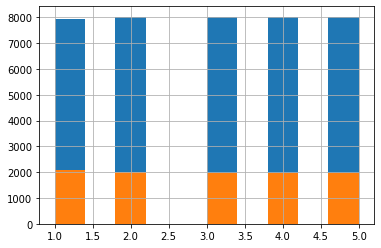

In [102]:

review_df = pd.concat([df_new[df_new['overall']==1.0].sample(n=10000),df_new[df_new['overall']==2.0].sample(n=10000),
                    df_new[df_new['overall']==3.0].sample(n=10000),df_new[df_new['overall']==4.0].sample(n=10000),
                    df_new[df_new['overall']==5.0].sample(n=10000)])
review_df = review_df[['cleanReview','overall']]
train, test = train_test_split(review_df, test_size=0.2)

train['overall'].hist();
test['overall'].hist();

train = pd.get_dummies(train, columns = ['overall'])
train.head()

test = pd.get_dummies(test, columns = ['overall'])
test.head()

train.shape, test.shape


In [103]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [104]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [105]:
class_names = ['overall_1.0', 'overall_2.0','overall_3.0','overall_4.0','overall_5.0']
scores = []
preds = np.zeros((len(test), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train['cleanReview'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train['cleanReview'].values, train_target)
    preds[:,i] = p.predict_proba(test['cleanReview'].values)[:,1]

CV score for class overall_1.0 is 0.8514749991893641
CV score for class overall_2.0 is 0.7940000678658036
CV score for class overall_3.0 is 0.7977499722478812
CV score for class overall_4.0 is 0.8018499997523186
CV score for class overall_5.0 is 0.8517000160642234


In [106]:
t = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      2071
           1       0.40      0.37      0.38      1995
           2       0.38      0.34      0.36      1983
           3       0.44      0.40      0.42      1980
           4       0.57      0.67      0.62      1971

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.48     10000
weighted avg       0.47      0.48      0.48     10000



## Some Other Multi-Class Classifier Models 

In [107]:
df_new=df_new.rename(columns = {'overall':'overall_rating'})
df_new['overall_rating'].value_counts()

5.0    115702
4.0    36215 
3.0    20788 
1.0    15830 
2.0    11465 
Name: overall_rating, dtype: int64

In [108]:
df_res = pd.concat([df_new[df_new['overall_rating']==1.0].sample(n=3000),df_new[df_new['overall_rating']==2.0].sample(n=3000),
                    df_new[df_new['overall_rating']==3.0].sample(n=3000),df_new[df_new['overall_rating']==4.0].sample(n=3000),
                    df_new[df_new['overall_rating']==5.0].sample(n=3000)])
df_res['overall_rating'].value_counts()

5.0    3000
4.0    3000
3.0    3000
2.0    3000
1.0    3000
Name: overall_rating, dtype: int64

In [109]:


df_100 = df_res.copy()

# v = TfidfVectorizer(max_features = 100000, min_df=10, max_df=0.60)
v = TfidfVectorizer(max_features = 10000, min_df=5,max_df=0.60)
x = v.fit_transform(df_100['cleanReview'])


df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
df_100 = df_100.drop('cleanReview', axis=1)

df_100.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)
# print(df_100)
res = pd.concat([df_100, df1], axis=1)
res.head(-20)

,overall_rating,reviewText,summary,cleanReviewLength,adjectives,aa,abandoned,abilities,ability,able,...,zagg,zaggs,zebra,zero,zerolemon,zipper,zone,zoom,zte,zune
0,1.0,"It advertises as rubber . after receiving this in the mail and seeing it was cheap plastic , I threw it away . was not worth hassel of sending back . Do not buy this as it is not rubber .",horrible,18,cheap worth,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,"I bought 2 of these ""otterbox"" of amazon. Within 3 months my wife had broke both. I threw away the first one thinking ""oh well, she must have been pretty rough on it,"" just for it to happen again. So I took it to a store in our mall to see if otterbox had a warranty. The store manager of this place tells me they do but they don't offer warranties to ones bought on amazon because most are fake. So just FYI don't buy one on amazon it may be fake! I have now bought my wife a new one at the store and it's done fine!","Poor, bad, and awful",49,first rough most fake fake new fine,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,I don't think this Dock is for Iphone.. It did not fit it. i have no use for it now. since the dock does not seem to be for iphone more for like an ipod touch.,Did not fit my Iphone4,16,more,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,"Bought this usb charger after reading all the rave reviews. All I can say is that this is a piece of junk. The cord is way too long for my liking. I prefer a cord that is the same length as the Apple model. Short enough to not get in the way. This cord is always tripping me up when I am at my desk because it is so lengthy! Very annoying. The charging takes FOREVER compared to my old Apple charger that recently fell apart. For instance, if I hook my phone up to this to charge at about 50% battery life it takes about an hour to get to 100%! This seems abnormally long to me. I actually hooked it in 15 minutes ago and it was at 90% and it is STILL only at 96%. Hmmmm. The charging times are just too long.\n\nThe WORST part about this charger to me would be the actual connecter. It doesn't fit snugly and ""click"" in place when you hook it in. It hangs in very loose and it has pulled out easily when touched lightly. It is just very, very flimsy and loose. I'm bummed that I shelled out 8 bucks for this when I probably could have gotten something of the same quality for two bucks on here. I think the best bet will be to just buy the official product from an apple store or apple.com. :(",HORRIBLE,100,usb rave same short lengthy old worst actual loose flimsy loose same best official,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,"this so called charger is no good. it looks nice but thats it, it does charger but it takes all day just to even charge half the battery, it is basically useless as a charger. stay away trust me.",a warning to all,20,called good nice charger useless,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,"This is a item that should be sold in the Dollar Stores for 50 cents. This charger is so cheap that when it does charge a battery i'm afraid it's not a true charge. If you wanna lose a friend,give them one of these that will do it. All that business about the floating pins is crap,they half float the spacers at the end of both [neg & pos] get in the way,you have to have the battery half way off the charger the spacers get in the way. .This should be name a battery holder or half holder.",Battery holder not charger.,43,cheap true,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,"The phone has an external PTT (push-to-talk aka press-to-transmit) button which is quite easy to depress inadvertently. That brings up a screen wanting to start a PTT activity. (PTT is an optional, extra cost feature that lets your phone act much like a walkie-talkie.) You then have 

In [110]:
res1 = res[res.columns.difference(['reviewText','summary', 'adjectives', 'overall_rating'])]
normalized_res1 = res1
# normalized_res1=(res1-res1.min())/(res1.max()-res1.min())
# print(normalized_res1.head(100))
y = res['overall_rating'].values.reshape(-1,1)

res1.shape, y.shape

# y = res['rating']
# len(y)

((15000, 5498), (15000, 1))

In [ ]:
df_new

## Logistic Regression Classifier

Multinomial Logistic regression Train Accuracy ::  0.67675
Multinomial Logistic regression Test Accuracy ::  0.459


Text(0.5, 257.44, 'Predicted label')

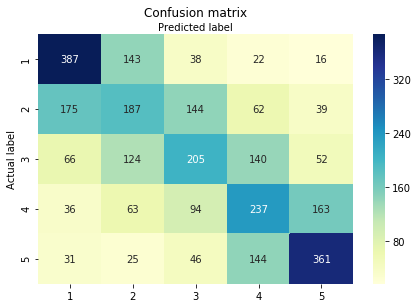

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state=101)
lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train,y_train)

print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, lr.predict(X_test))


class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## KNN Classifier

0.322


Text(0.5, 257.44, 'Predicted label')

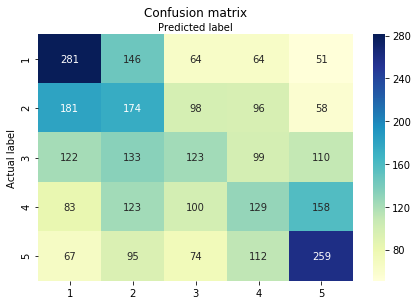

In [114]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2,random_state=101)
knn = KNeighborsClassifier(n_neighbors = 100).fit(X_train, y_train)

accuracy = knn.score(X_test, y_test) 
print (accuracy)
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cnf_matrix = metrics.confusion_matrix(y_test, knn_predictions) 

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## SVM Linear Classifier

Multinomial SVM Train Accuracy ::  0.6388333333333334
Multinomial SVM Test Accuracy ::  0.383


Text(0.5, 257.44, 'Predicted label')

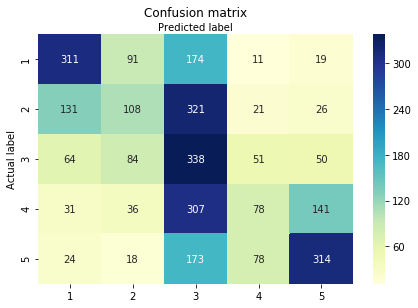

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state=101)
svm = LinearSVC()
svm.fit(X_train,y_train)

print ("Multinomial SVM Train Accuracy :: ", metrics.accuracy_score(y_train, svm.predict(X_train)))
print ("Multinomial SVM Test Accuracy :: ", metrics.accuracy_score(y_test, svm.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, svm.predict(X_test))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Multinomial Multinomial Naive Bayes Train Accuracy ::  0.58936
Multinomial Multinomial Naive Bayes Accuracy ::  0.59168


Text(0.5, 257.44, 'Predicted label')

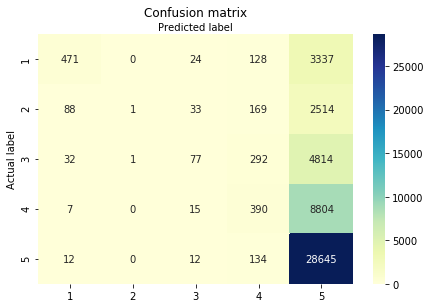

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df_new['cleanReview'], df_new['overall_rating'], random_state = 101)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
print ("Multinomial Multinomial Naive Bayes Train Accuracy :: ", metrics.accuracy_score(y_train, clf.predict(X_train_tfidf)))
print ("Multinomial Multinomial Naive Bayes Accuracy :: ", metrics.accuracy_score(y_test, clf.predict(count_vect.transform(X_test))))

cnf_matrix = metrics.confusion_matrix(y_test, clf.predict(count_vect.transform(X_test)))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')